<h2> LSTM Models <h2>


Create various LSTM Models and evaluating them<br>

**NOTE: Using a dataset with 10 of the best performing feature based on another student analysis**

**Features (x):**<br>
- *soil_vwc*
- *water_24h*
- *water_36h*
- *water_48h*
- *global_radiation_flux_ds_24h*
- *global_radiation_flux_ds_36h*
- *global_radiation_flux_ds_48h*
- *temperature 24/36/48h*


**Target (y)** is *soil_vwc*

<br><br>


Reading the dataset file

In [4]:
df_scaled

,soil_vwc,global_radiation_flux_ds_72h,water_72h,temperature_ds_72h,global_radiation_flux_ds_48h,water_48h,temperature_ds_48h,global_radiation_flux_ds_24h,water_24h,temperature_ds_36h,temperature_ds_24h
timestamp,,,,,,,,,,,
2023-07-11 10:10:00,-0.211271,2.357551,-4.442229,0.850424,2.237543,-4.296776,0.838971,2.073266,-3.897261,0.834509,0.833888
2023-07-11 10:20:00,-0.162457,2.483610,-4.405672,0.884035,2.355829,-4.243707,0.871565,2.181353,-3.800145,0.866583,0.865572
2023-07-11 10:30:00,-0.143942,2.614781,-4.368756,0.924253,2.478911,-4.190115,0.910567,2.293824,-3.702072,0.904963,0.903486
2023-07-11 10:40:00,-0.123743,2.790633,-4.331523,0.958531,2.643918,-4.136062,0.943808,2.444605,-3.603156,0.937674,0.935800
2023-07-11 10:50:00,-0.118693,2.952094,-4.294231,0.985525,2.795422,-4.081926,0.969985,2.583047,-3.504088,0.963433,0.961247
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-19 23:10:00,-0.446924,-1.794187,-1.702030,-0.664027,-1.826008,-1.842031,-0.674240,-0.798619,-0.796900,-0.736295,-0.751437
2023-09-19 23:20:00,-0.448607,-1.794187,-1.702030,-0.665409,-1.826008,-1.842031,-0.677166,-0.798619,-0.796900,-0.734416,-0.752926
2023-09-19 23:30:00,-0.446924,-1.794187,-1.702030,-0.666947,-1.826008,-1.842031,-0.679962,-0.798619,-0.796900,-0.732932,-0.754253


<h3> Organizing data in time series <h3>

In [124]:
# Data Preparation for neural network



def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = df.iloc[i + j].values
            res.append(r)
        xRes.append(res)
        yRes.append(df[['soil_vwc']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)


def multiStepSampler(df, window, future_steps, step_size):
    xRes = []
    yRes = []
    for i in range(0, len(df) - (window * step_size) - future_steps + 1):
        res = []
        for j in range(0, window):
            r = df.iloc[i + j * step_size].values  
            res.append(r)
        xRes.append(res)
        yRes.append(df[['soil_vwc']].iloc[i + window * step_size + future_steps - 1].values)
    return np.array(xRes), np.array(yRes)






For now using Window size = 5 and 80%-20% train-test suddivision

In [126]:
import pandas as pd
import numpy as np

# reading the ds file
df_scaled = pd.read_excel("./2023-stuard/df_best_scaled.xlsx", index_col=0)

# Costant values:
WINDOWS_SIZE = 5
SPLIT = 0.2
FUTURE_STEPS = 6  # Number of Future steps that we want to predict
STEP_SIZE = 6

X_temp, y_temp = multiStepSampler(df_scaled, WINDOWS_SIZE, FUTURE_STEPS, STEP_SIZE )

# Split data into training and testing
X_train = X_temp[int(SPLIT * len(X_temp)):]
y_train = y_temp[int(SPLIT * len(y_temp)):]
X_test = X_temp[:int(SPLIT * len(X_temp))]
y_test = y_temp[:int(SPLIT * len(y_temp))]


X_train.shape, y_train.shape, X_test.shape, y_test.shape  # Check shapes


((8093, 5, 11), (8093, 1), (2023, 5, 11), (2023, 1))

In [127]:
# isolating the timestamp column to merge with the predictions in a second moment
df_copy = df_scaled
df_copy = df_copy.reset_index()
df_copy = df_copy[['timestamp']]

<h1> Building LSTM Models <h1> 

## First Model (lstmModel_1)

- 1 lstm layer (8 neurons)
- 1 Output layer
- 50 epochs

Trying using a **validation** set (33% of train set) to calculate loss and MAE every epoch.

Model: "lstmModel_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 8)                   │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - MAE: 1.0593 - loss: 1.6131 - val_MAE: 0.4536 - val_loss: 0.3540
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - MAE: 0.6097 - loss: 0.5560 - val_MAE: 0.3401 - val_loss: 0.2144
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - MAE: 0.3118 - loss: 0.1494 - val_MAE: 0.3350 - val_loss: 0.1758
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - MAE: 0.2347 - loss: 0.0979 - val_MAE: 0.3302 - val_loss: 0.1551
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - MAE: 0.2070 - loss: 0.0770 - val_MAE: 0.3222 - val_loss: 0.1437
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - MAE: 0.1846 - loss: 0.0624 - val_MAE: 0.3082 - val_loss: 0.1340
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - MAE: 0.1667 - loss: 0.0511 - val_MAE: 0.2933 - val_loss: 0.1264
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - MAE: 0.1509 - loss: 0.0434 - val_MAE: 0.2800 - val_loss: 0.1183
Epoch 9/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - M

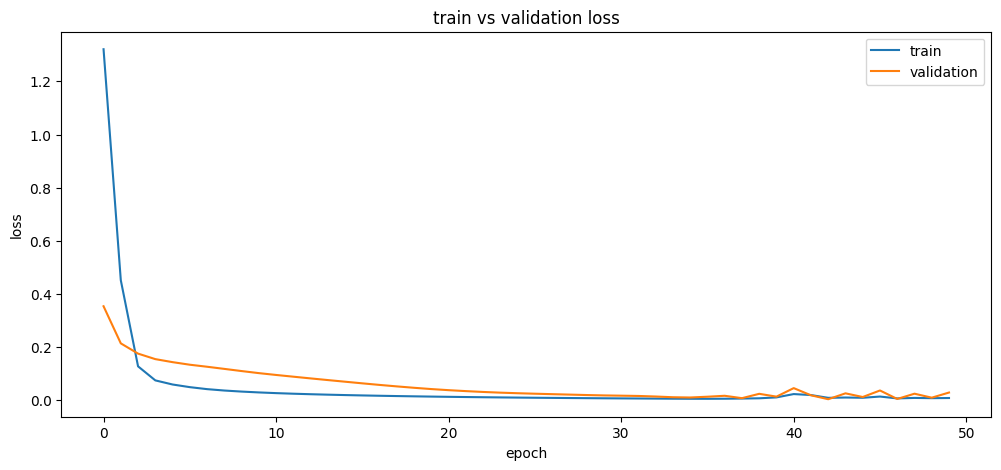

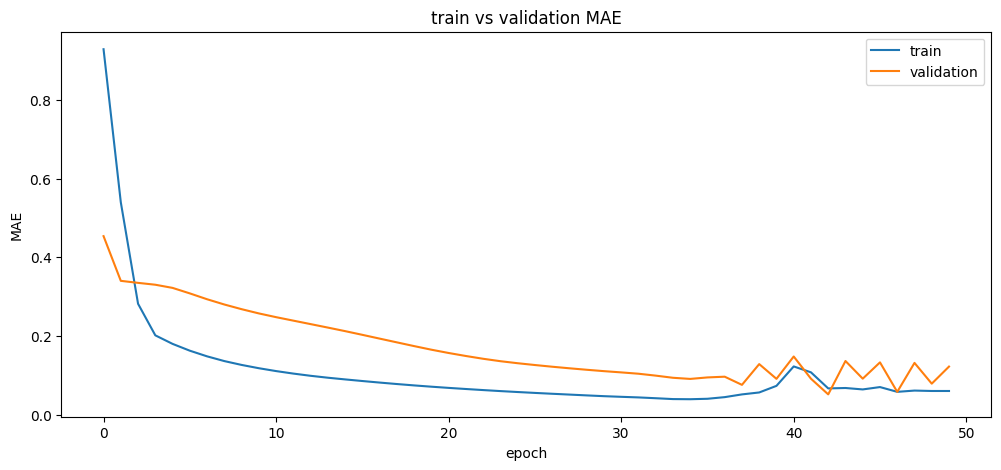

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Create model structure
lstmModel_1 = keras.Sequential(name="lstmModel_1")
lstmModel_1.add(keras.layers.LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), name="LSTM_1")) 
lstmModel_1.add(keras.layers.Dense(1, activation='linear', name="Dense_1"))  # Output layer
lstmModel_1.compile(loss='MeanSquaredError', metrics=['MAE'], optimizer=Adam(learning_rate=0.001))
lstmModel_1.summary()

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model using created callback
history = lstmModel_1.fit(X_train, y_train, epochs=50, validation_split=0.33, shuffle=False)

# Loss Graph in train and validation
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


# MAE Graph in train and validation
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.title('train vs validation MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


## Second Model (lstmModel_2)

Model: "lstmModel_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 5, 64)               │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,657 (96.32 KB)

 Trainable params: 24,657 (96.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - MAE: 0.5438 - loss: 0.4983 - val_MAE: 0.4354 - val_loss: 0.2867
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - MAE: 0.3457 - loss: 0.2396 - val_MAE: 0.6503 - val_loss: 0.7954
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - MAE: 0.3187 - loss: 0.1703 - val_MAE: 0.5889 - val_loss: 0.4903
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - MAE: 0.2575 - loss: 0.1109 - val_MAE: 0.3204 - val_loss: 0.1366
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - MAE: 0.2218 - loss: 0.0850 - val_MAE: 0.2843 - val_loss: 0.1119
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - MAE: 0.2040 - loss: 0.0729 - val_MAE: 0.1803 - val_loss: 0.0608
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - MAE: 0.1938 - loss: 0.0742 - val_MAE: 0.2282 - val_loss: 0.0712
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - MAE: 0.1311 - loss: 0.0347 - val_MAE: 0.1262 - val_loss: 0.0222
Epoch 9/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms

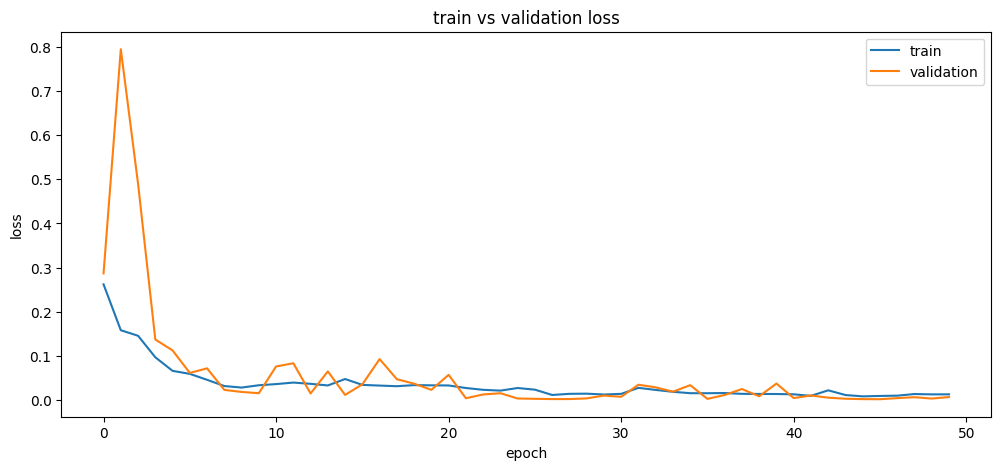

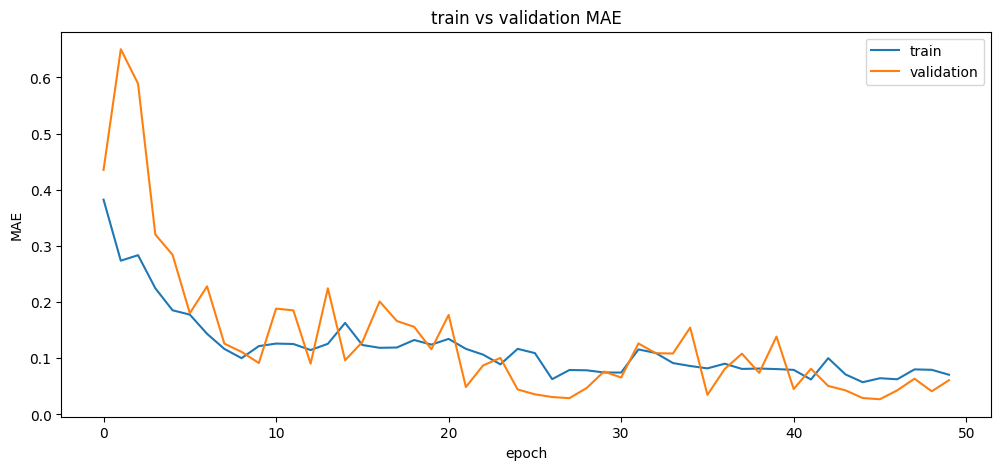

In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import keras
import matplotlib.pyplot as plt


# Create model structure
lstmModel_1 = keras.Sequential(name="lstmModel_2")
lstmModel_1.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, name="LSTM_1")) 
lstmModel_1.add(keras.layers.Dropout(0.2)) # Dropout layer to prevent overfitting
lstmModel_1.add(keras.layers.LSTM(16, name="LSTM_2")) 
lstmModel_1.add(keras.layers.Dense(1, activation='linear', name="Dense_1"))  # Output layer
lstmModel_1.compile(loss='MeanSquaredError', metrics=['MAE'], optimizer=Adam(learning_rate=0.001))
lstmModel_1.summary()

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model using created callback
history = lstmModel_1.fit(X_train, y_train, epochs=50, validation_split=0.33, shuffle=False)

# Loss Graph in train and validation
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


# MAE Graph in train and validation
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.title('train vs validation MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


## First Model (lstmModel_1) with test and SMAPE

- 1 lstm layer (8 neurons)
- 1 Output layer
- 50 epochs

Using test set to calculate smape after every epoch

Model: "lstmModel_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 8)                   │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
249/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAE: 1.0810 - loss: 1.6706 - smape: 176.4966
Epoch 1 - Test Loss: 1.2845, Test MAE: 0.9455, Test SMAPE: 162.5870
254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - MAE: 1.0755 - loss: 1.6587 - smape: 176.2165
Epoch 2/50
252/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAE: 0.7378 - loss: 0.8428 - smape: 117.9994
Epoch 2 - Test Loss: 0.8109, Test MAE: 0.7281, Test SMAPE: 112.5576
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - MAE: 0.7360 - loss: 0.8398 - smape: 117.9107
Epoch 3/50
252/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAE: 0.4544 - loss: 0.3485 - smape: 70.7888
Epoch 3 - Test Loss: 0.4052, Test MAE: 0.4813, Test SMAPE: 74.5887
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - MAE: 0.4532 - loss: 0.3471 - smape: 70.7248
Epoch 4/50
248/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MAE: 0.2673 - loss: 0.1249 - smape: 48.6953
Epoch 4 - Test Loss: 0.3039, Test MAE: 0.3931, Test SMAPE: 67.8666
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - MAE: 0.2663 - loss: 0.1241 - 

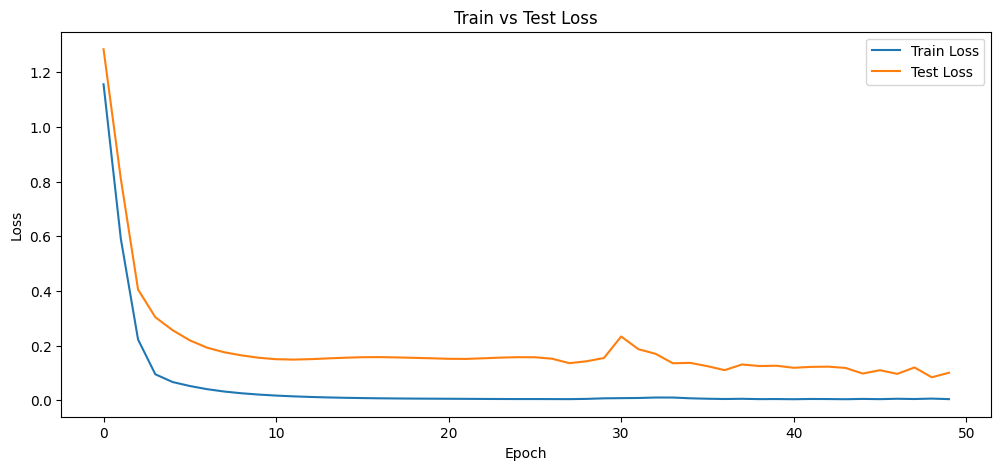

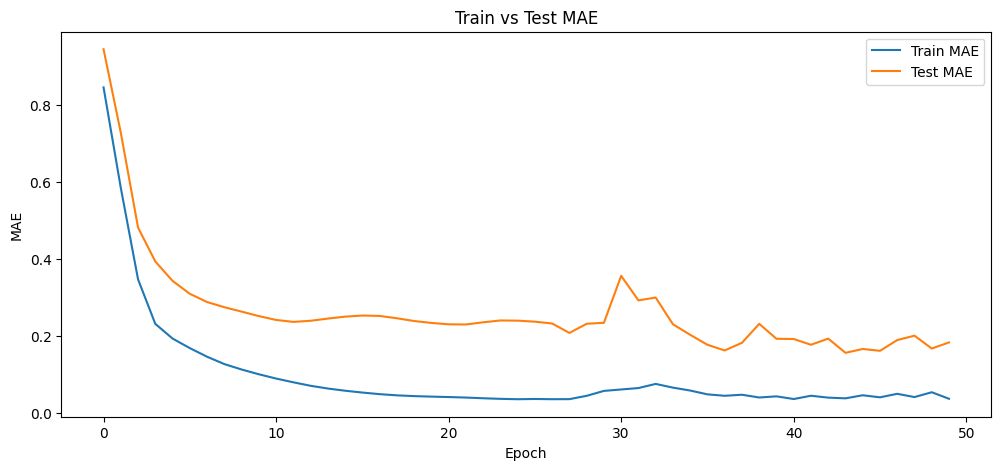

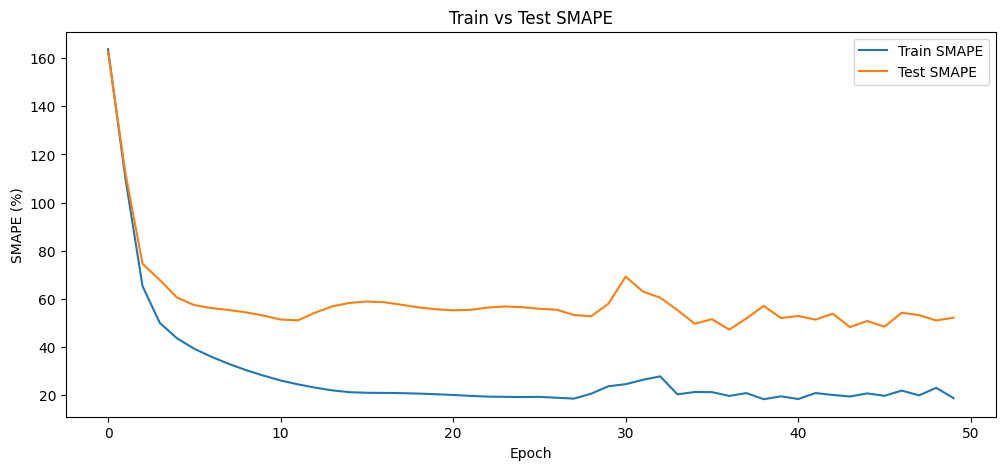

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


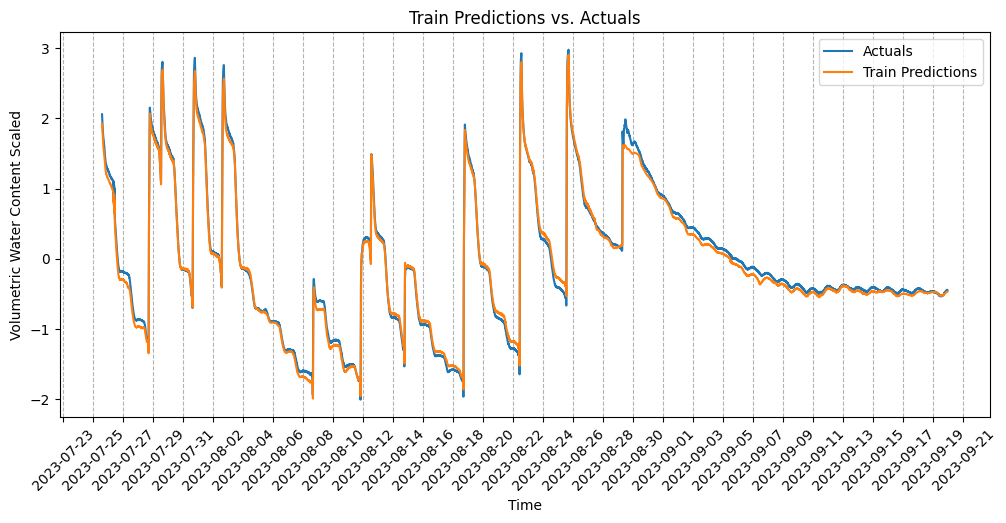

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


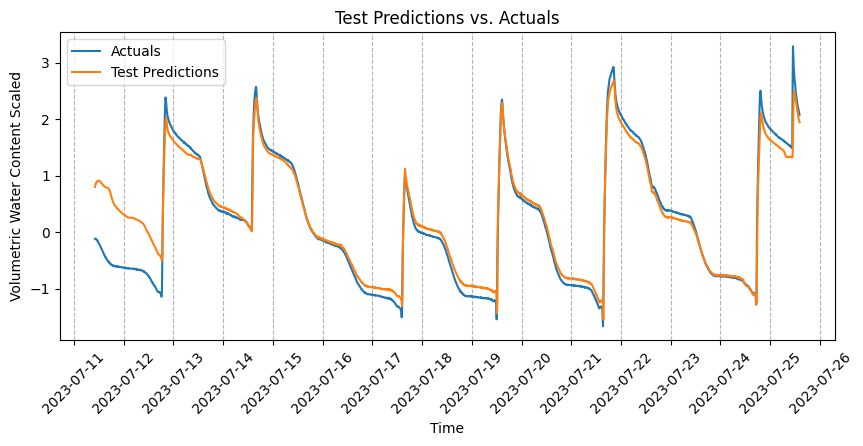

In [48]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import matplotlib.dates as mdates


# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


# Create model structure
lstmModel_1 = keras.Sequential(name="lstmModel_1")
lstmModel_1.add(keras.layers.LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2]), name="LSTM_1")) 
lstmModel_1.add(keras.layers.Dense(1, activation='linear', name="Dense_1"))  # Output layer
lstmModel_1.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.001))
lstmModel_1.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = lstmModel_1.fit(X_train, y_train, epochs=50, shuffle=False, callbacks=[test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


#TRAIN DATA VISUALIZATION

train_predictions = lstmModel_1.predict(X_train).flatten()
y_train = y_train.flatten()

# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5] 

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})

# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = lstmModel_1.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


## Second Model (lstmModel_2) with test and SMAPE

- 2 lstm layer (64-16 neurons)
- 1 dropout layer 
- 1 Output layer
- 50 epochs
  
Using test set to calculate smape after every epoch

Model: "lstmModel_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 5, 64)               │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,657 (96.32 KB)

 Trainable params: 24,657 (96.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MAE: 0.5539 - loss: 0.5141 - smape: 92.4158
Epoch 1 - Test Loss: 0.1966, Test MAE: 0.3291, Test SMAPE: 63.5388
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - MAE: 0.5526 - loss: 0.5122 - smape: 92.2953
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - MAE: 0.2411 - loss: 0.1015 - smape: 48.5649
Epoch 2 - Test Loss: 0.0813, Test MAE: 0.2045, Test SMAPE: 46.6336
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - MAE: 0.2411 - loss: 0.1015 - smape: 48.5871
Epoch 3/50
249/254 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MAE: 0.1947 - loss: 0.0683 - smape: 40.7392
Epoch 3 - Test Loss: 0.1190, Test MAE: 0.2806, Test SMAPE: 52.7990
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - MAE: 0.1943 - loss: 0.0681 - smape: 40.7679
Epoch 4/50
249/254 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - MAE: 0.1976 - loss: 0.0708 - smape: 38.4401
Epoch 4 - Test Loss: 0.0936, Test MAE: 0.2258, Test SMAPE: 47.5351
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - MAE: 0.1963 - loss: 0.0702 

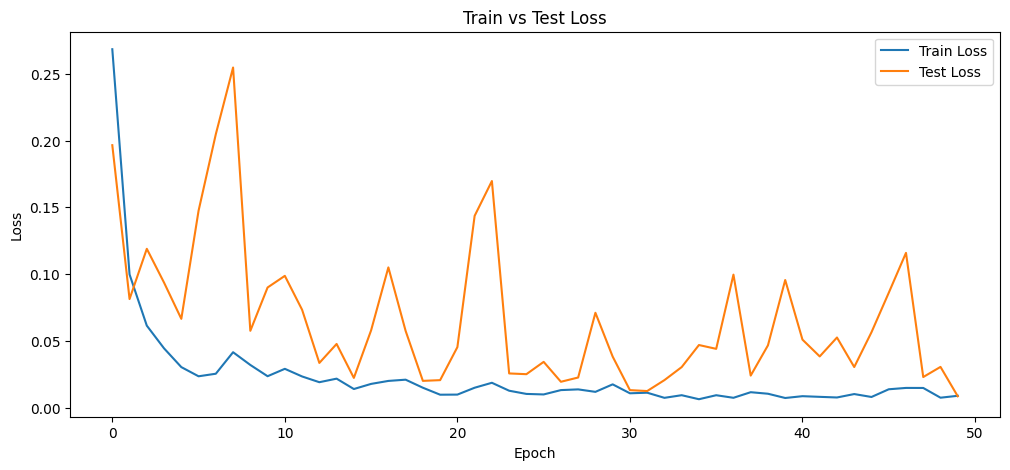

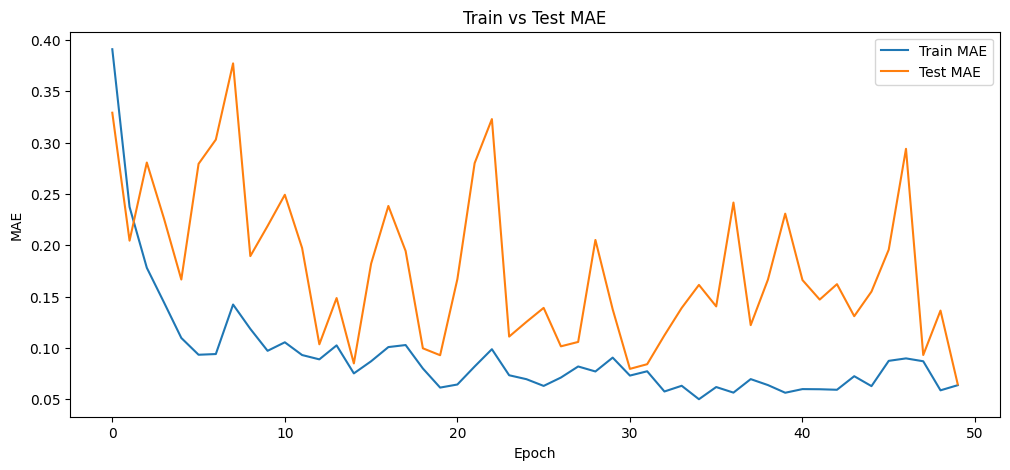

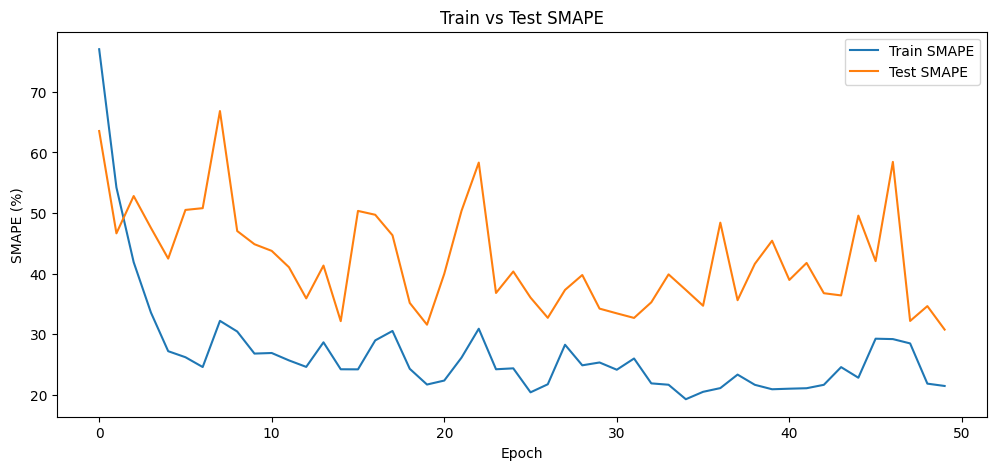

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


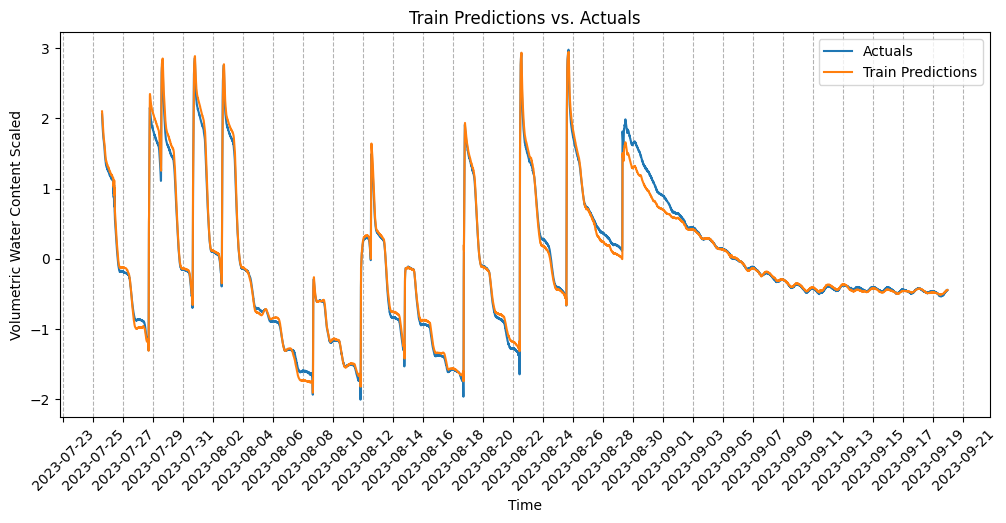

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


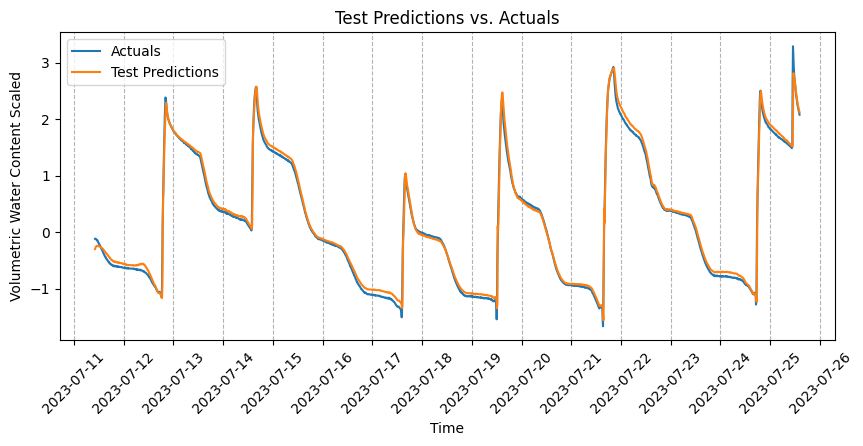

In [49]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")



# Create model structure
lstmModel_2 = keras.Sequential(name="lstmModel_2")
lstmModel_2.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, name="LSTM_1")) 
lstmModel_2.add(keras.layers.Dropout(0.3))  # Dropout layer to prevent overfitting
lstmModel_2.add(keras.layers.LSTM(16, name="LSTM_2")) 
lstmModel_2.add(keras.layers.Dense(1, activation='linear', name="Dense_1"))  # Output layer
lstmModel_2.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.001))
lstmModel_2.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = lstmModel_2.fit(X_train, y_train, epochs=50, shuffle=False, callbacks=[test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


#TRAIN DATA VISUALIZATION

train_predictions = lstmModel_2.predict(X_train).flatten()
y_train = y_train.flatten()

# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5] 

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})

# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = lstmModel_2.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


## lstmModel_1 with EarlyStopping  and ReduceOnPlateau

Model: "lstmModel_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 32)                  │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,665 (22.13 KB)

 Trainable params: 5,665 (22.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.7016 - loss: 0.7713 - smape: 116.5823
Epoch 1 - Test Loss: 0.1502, Test MAE: 0.3018, Test SMAPE: 57.0999
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - MAE: 0.7009 - loss: 0.7701 - smape: 116.5000 - learning_rate: 0.0010
Epoch 2/50
248/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.2667 - loss: 0.1358 - smape: 45.7761
Epoch 2 - Test Loss: 0.0899, Test MAE: 0.2178, Test SMAPE: 40.1283
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MAE: 0.2661 - loss: 0.1355 - smape: 45.9128 - learning_rate: 0.0010
Epoch 3/50
242/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.1989 - loss: 0.0831 - smape: 35.8107
Epoch 3 - Test Loss: 0.0615, Test MAE: 0.1359, Test SMAPE: 24.9435
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MAE: 0.1982 - loss: 0.0826 - smape: 36.0409 - learning_rate: 0.0010
Epoch 4/50
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.1909 - loss: 0.0772 - smape: 33.1068
Epoch 4 - Test Loss: 0.0644, Test MAE: 0.1301, Test SMAPE: 23.5905
254/2

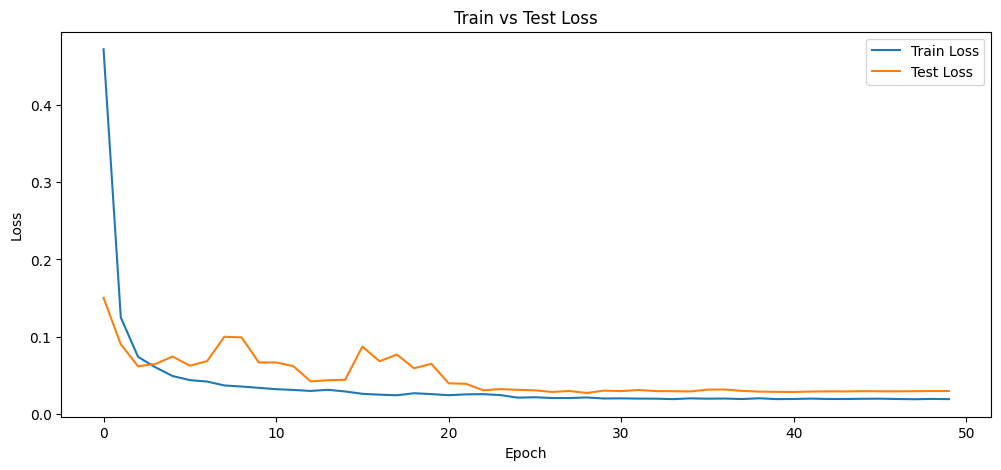

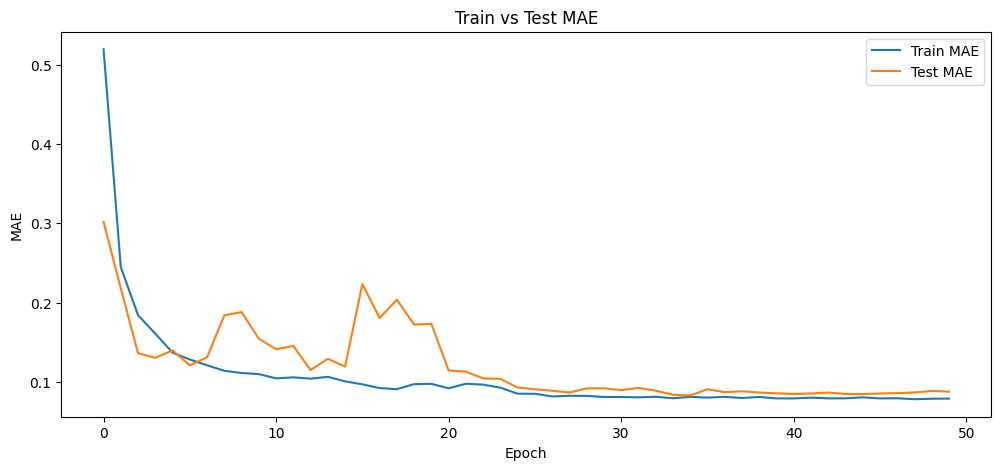

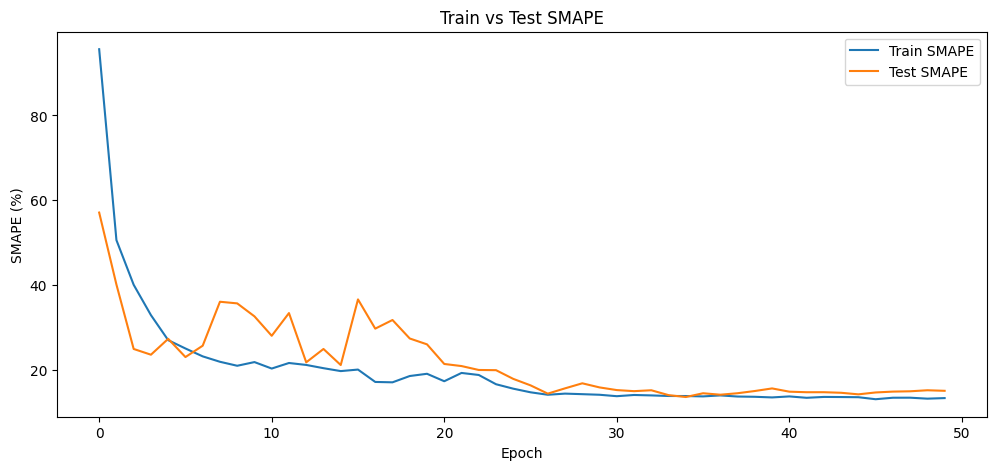

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


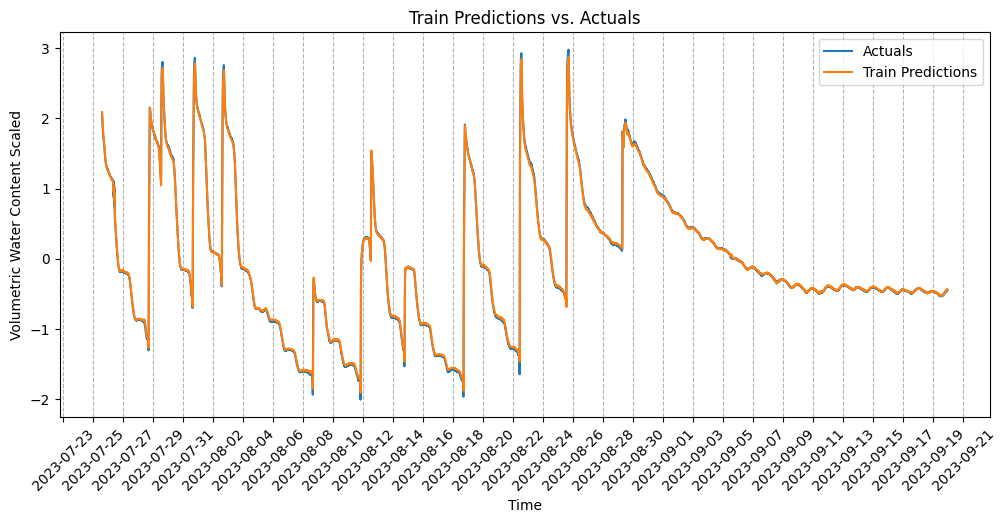

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


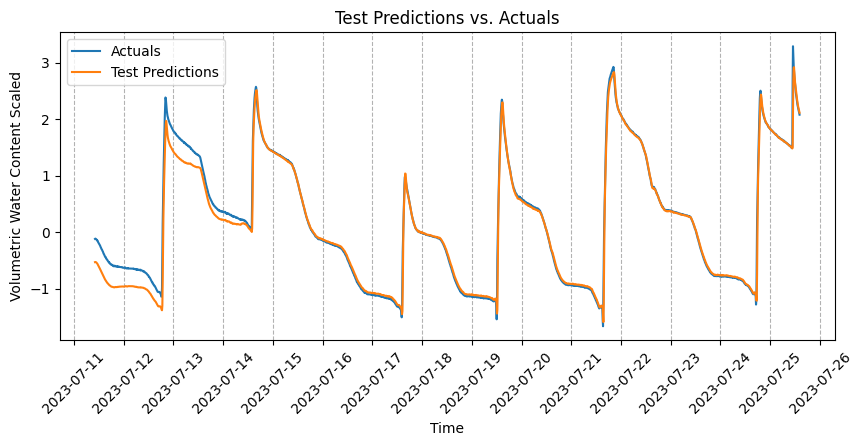

In [66]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import matplotlib.dates as mdates
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


# Create model structure
lstmModel_1 = keras.Sequential(name="lstmModel_1")
lstmModel_1.add(keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.0005), name="LSTM_1")) 
lstmModel_1.add(keras.layers.Dropout(0.3))  # Dropout layer to prevent overfitting
lstmModel_1.add(keras.layers.Dense(1, activation='linear',kernel_regularizer=l2(0.0005), name="Dense_1"))  # Output layer
lstmModel_1.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.001))
lstmModel_1.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='MAE', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='MAE', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = lstmModel_1.fit(X_train, y_train, epochs=50, shuffle=False, callbacks=[early_stopping,reduce_lr, test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


#TRAIN DATA VISUALIZATION

train_predictions = lstmModel_1.predict(X_train).flatten()
y_train = y_train.flatten()


# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5]

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})


# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = lstmModel_1.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()




## lstmModel_2 with EarlyStopping and ReduceOnPlateau

C:\Users\coste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstmModel_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 5, 64)               │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
251/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAE: 0.5518 - loss: 0.6371 - smape: 93.8283
Epoch 1 - Test Loss: 0.1698, Test MAE: 0.2210, Test SMAPE: 47.9783
254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - MAE: 0.5487 - loss: 0.6323 - smape: 93.4486 - learning_rate: 0.0010
Epoch 2/60
245/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAE: 0.2112 - loss: 0.1503 - smape: 42.2843
Epoch 2 - Test Loss: 0.1333, Test MAE: 0.1785, Test SMAPE: 41.5796
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - MAE: 0.2113 - loss: 0.1501 - smape: 42.5141 - learning_rate: 0.0010
Epoch 3/60
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAE: 0.2000 - loss: 0.1243 - smape: 42.1477
Epoch 3 - Test Loss: 0.1354, Test MAE: 0.2186, Test SMAPE: 46.6015
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - MAE: 0.1998 - loss: 0.1242 - smape: 42.1315 - learning_rate: 0.0010
Epoch 4/60
251/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MAE: 0.1997 - loss: 0.1182 - smape: 37.2063
Epoch 4 - Test Loss: 0.1054, Test MAE: 0.1761, Test SMAPE: 38.6861
254/25

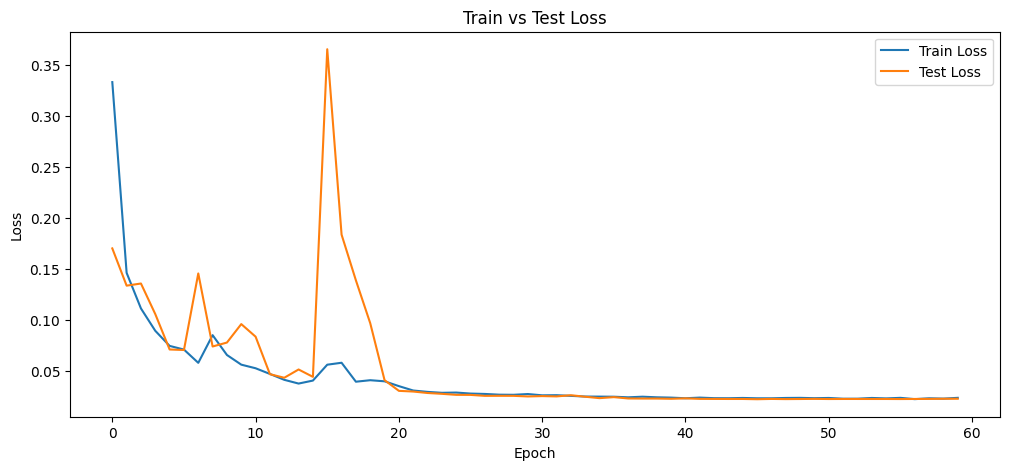

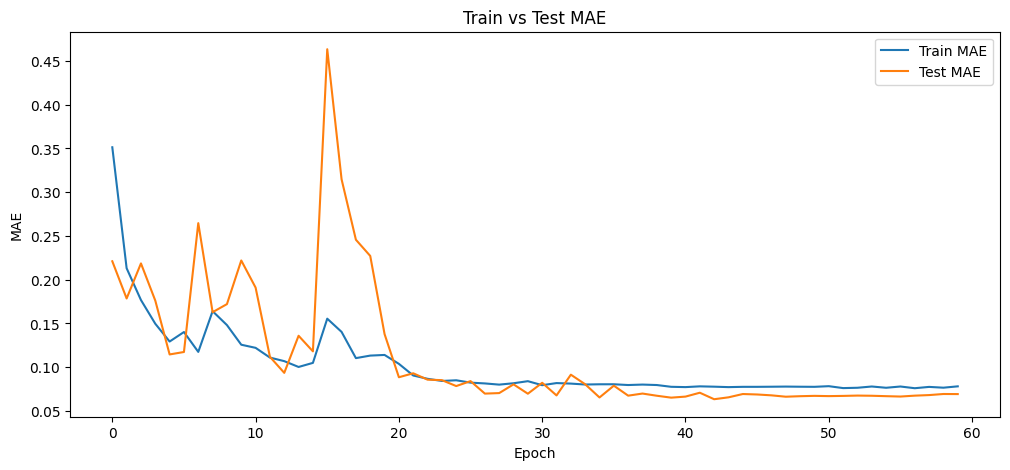

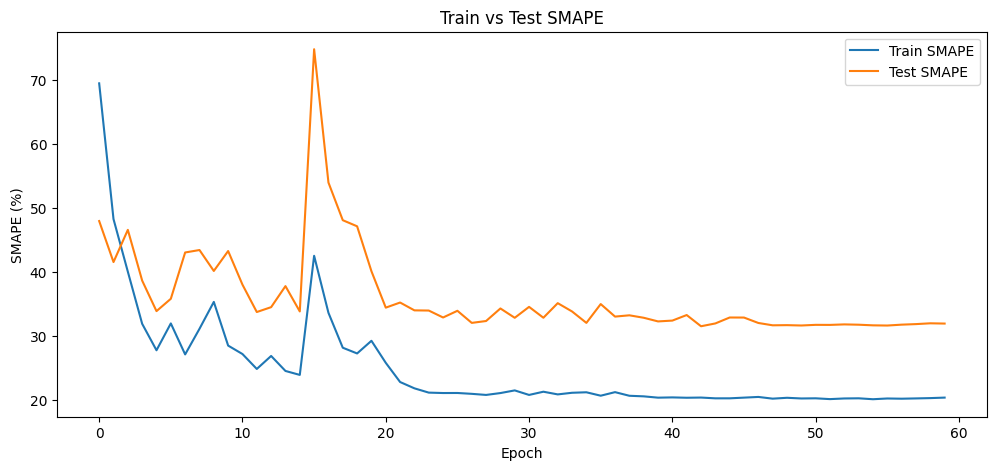

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


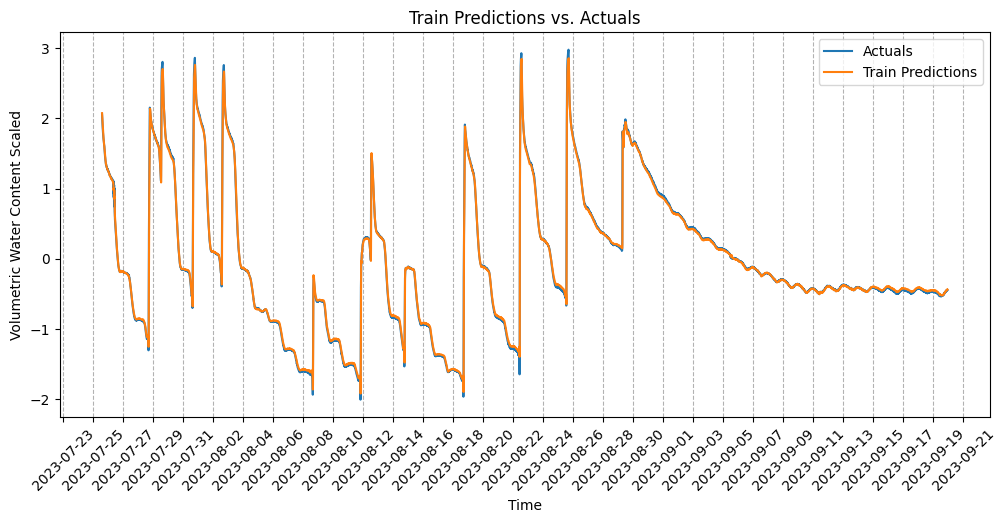

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


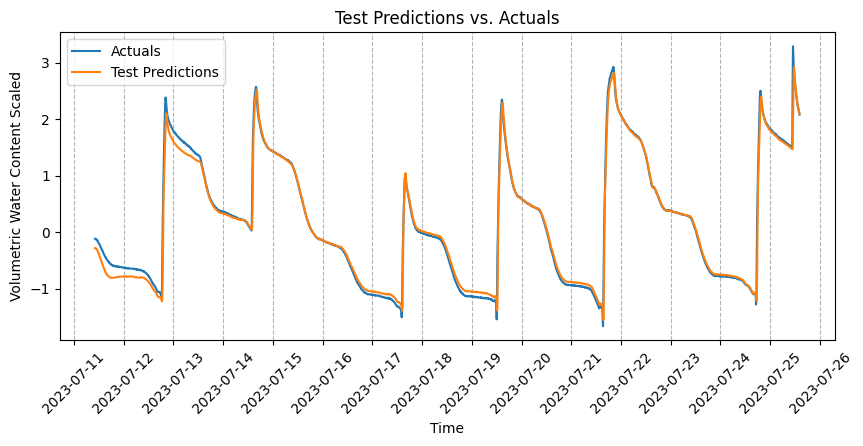

In [41]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


    
# Create model structure
lstmModel_2 = keras.Sequential(name="lstmModel_2")
lstmModel_2.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001), return_sequences=True, name="LSTM_1")) 
lstmModel_2.add(keras.layers.LSTM(32,kernel_regularizer=l2(0.001), name="LSTM_2")) 
lstmModel_2.add(keras.layers.Dropout(0.3))  # Dropout layer to prevent overfitting
lstmModel_2.add(keras.layers.Dense(1, activation='linear', name="Dense_1"))  # Output layer
lstmModel_2.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.001))
lstmModel_2.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# callbacks
early_stopping = EarlyStopping(monitor='MAE', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='MAE', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = lstmModel_2.fit(X_train, y_train, epochs=60, shuffle=False, callbacks=[early_stopping,reduce_lr, test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


#TRAIN DATA VISUALIZATION

train_predictions = lstmModel_2.predict(X_train).flatten()
y_train = y_train.flatten()


# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5]

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})


# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = lstmModel_2.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()

## lstmModel_3 
Most simple one-layered model

C:\Users\coste\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstmModel_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 6)                   │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439 (1.71 KB)

 Trainable params: 439 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
234/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.9955 - loss: 1.4908 - smape: 167.4584
Epoch 1 - Test Loss: 1.0596, Test MAE: 0.8270, Test SMAPE: 151.2245
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - MAE: 0.9805 - loss: 1.4597 - smape: 166.1057
Epoch 2/60
247/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.9599 - loss: 1.4037 - smape: 163.0853
Epoch 2 - Test Loss: 1.0168, Test MAE: 0.8106, Test SMAPE: 147.8496
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MAE: 0.9543 - loss: 1.3923 - smape: 162.5946
Epoch 3/60
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.9325 - loss: 1.3369 - smape: 159.4473
Epoch 3 - Test Loss: 0.9731, Test MAE: 0.7932, Test SMAPE: 144.1791
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MAE: 0.9318 - loss: 1.3355 - smape: 159.3937
Epoch 4/60
246/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.9081 - loss: 1.2727 - smape: 155.1994
Epoch 4 - Test Loss: 0.9283, Test MAE: 0.7746, Test SMAPE: 140.2781
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MAE: 0.9022 - loss: 1.260

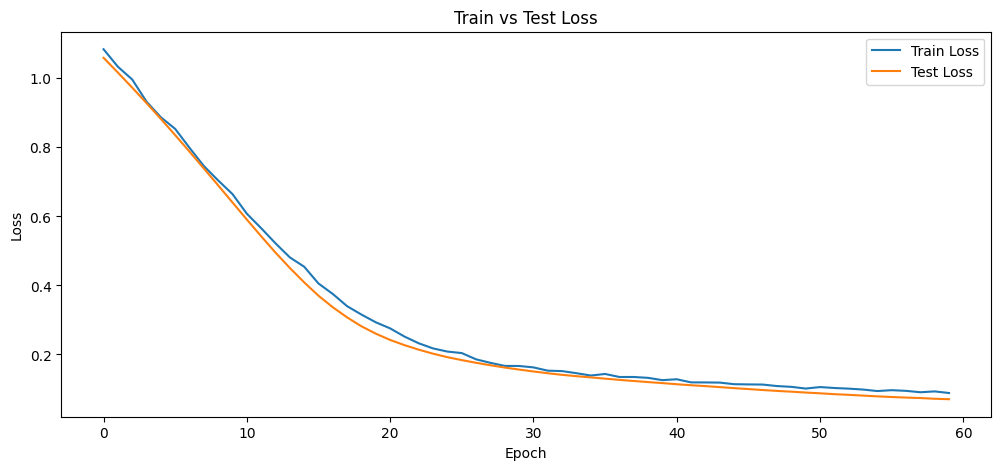

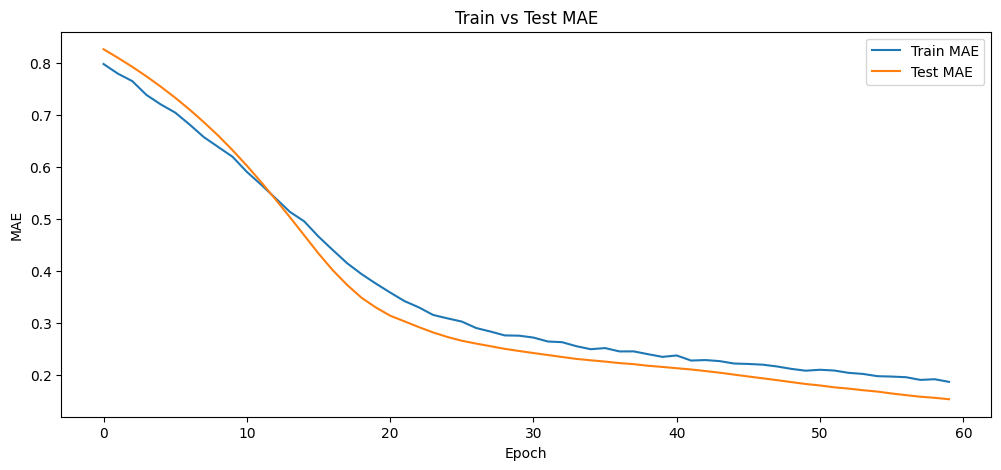

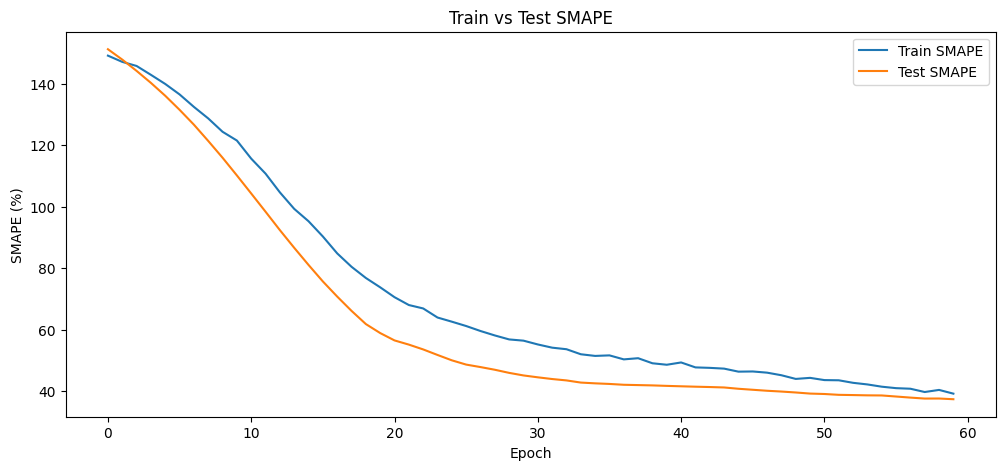

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


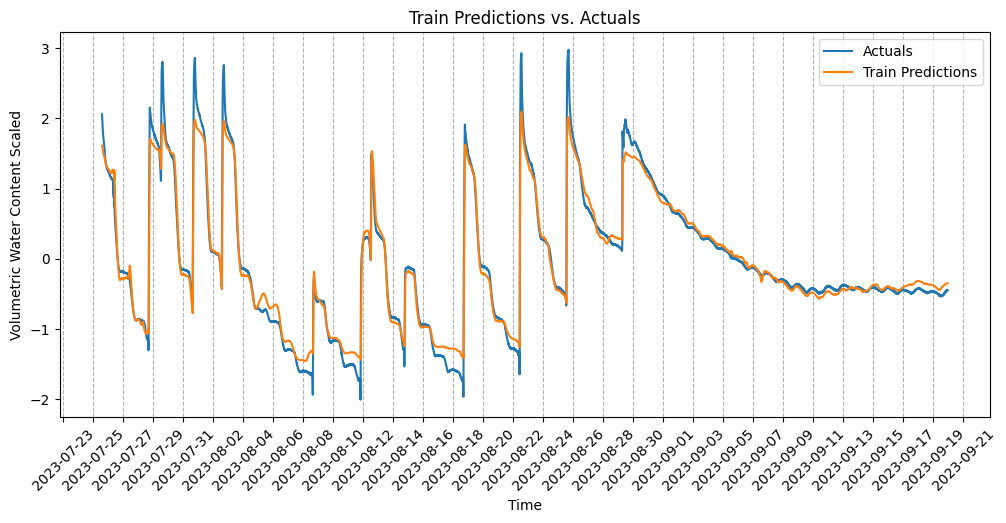

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


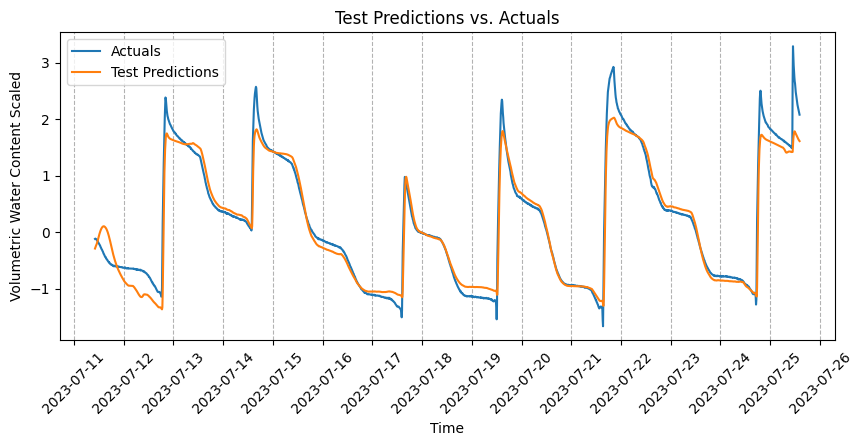

In [43]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import matplotlib.dates as mdates
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


# Create model structure
lstmModel_3 = keras.Sequential(name="lstmModel_3")
lstmModel_3.add(keras.layers.LSTM(6, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.001), name="LSTM_1")) 
lstmModel_3.add(keras.layers.Dropout(0.2))  # Dropout layer to prevent overfitting
lstmModel_3.add(keras.layers.Dense(1, activation='linear',kernel_regularizer=l2(0.001), name="Dense_1"))  # Output layer
lstmModel_3.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.0001))
lstmModel_3.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# Earlu Stopping Callback
early_stopping = EarlyStopping(monitor='MAE', patience=4, restore_best_weights=True, verbose=1)

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = lstmModel_3.fit(X_train, y_train, epochs=60, shuffle=False, callbacks=[early_stopping, test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


#TRAIN DATA VISUALIZATION

train_predictions = lstmModel_3.predict(X_train).flatten()
y_train = y_train.flatten()


# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5]

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})


# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = lstmModel_3.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()





## lstmModel_4 with EarlyStopping and ReduceOnPlateau
Most complex stacked model

Model: "lstmModel_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 5, 128)              │          71,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (None, 5, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,049 (523.63 KB)

 Trainable params: 134,049 (523.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - MAE: 0.6384 - loss: 0.8558 - smape: 116.6176
Epoch 1 - Test Loss: 0.9803, Test MAE: 0.7412, Test SMAPE: 137.3505
254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - MAE: 0.6378 - loss: 0.8547 - smape: 116.5842 - learning_rate: 0.0010
Epoch 2/100
252/254 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - MAE: 0.4473 - loss: 0.5109 - smape: 68.4947
Epoch 2 - Test Loss: 0.2641, Test MAE: 0.3437, Test SMAPE: 61.7837
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - MAE: 0.4460 - loss: 0.5089 - smape: 68.4325 - learning_rate: 0.0010
Epoch 3/100
252/254 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - MAE: 0.3566 - loss: 0.3229 - smape: 54.5263
Epoch 3 - Test Loss: 0.2731, Test MAE: 0.2689, Test SMAPE: 44.3707
254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - MAE: 0.3556 - loss: 0.3220 - smape: 54.4431 - learning_rate: 0.0010
Epoch 4/100
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - MAE: 0.2886 - loss: 0.2384 - smape: 46.1126
Epoch 4 - Test Loss: 0.2126, Test MAE: 0.2512, Test SMAPE: 

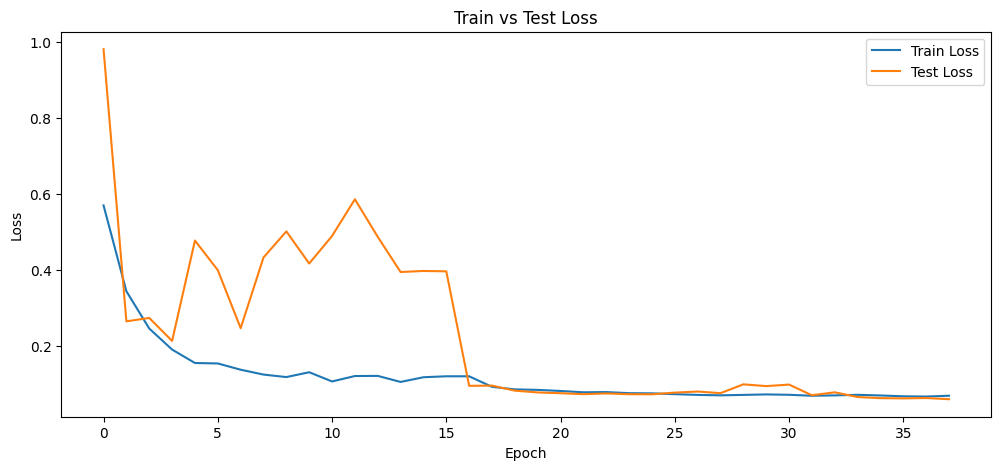

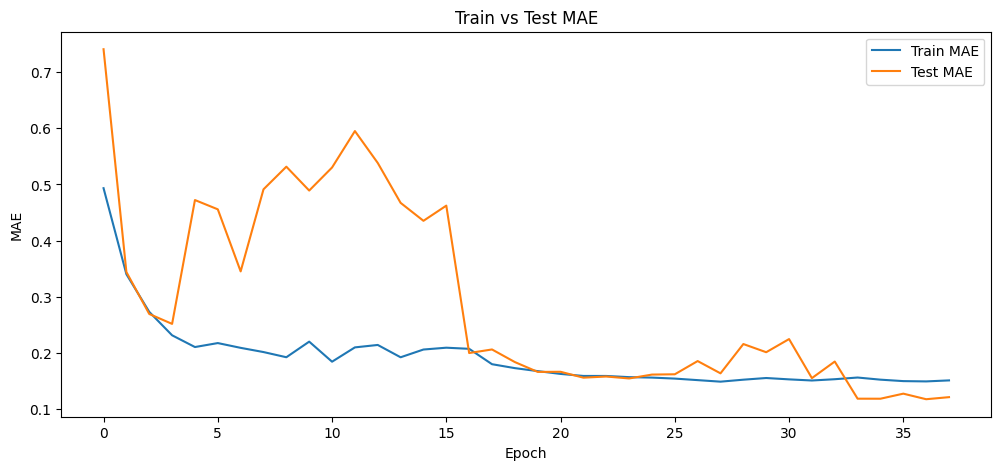

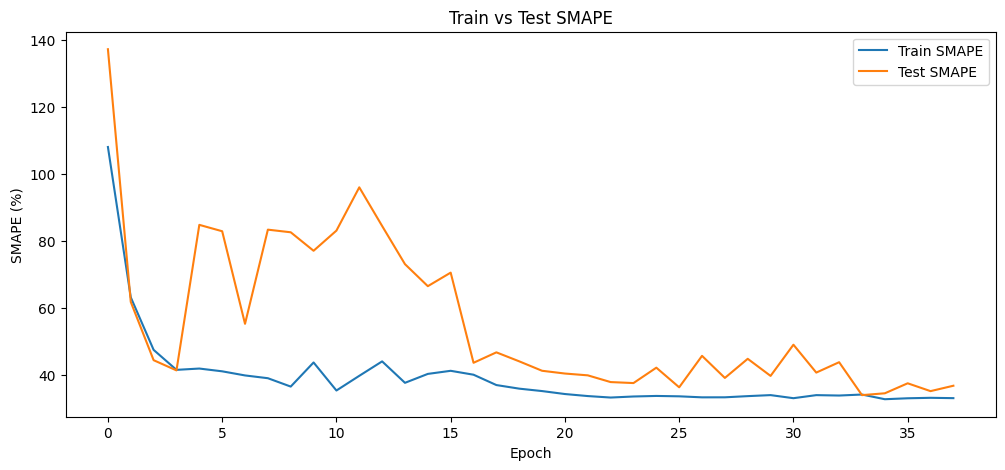

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


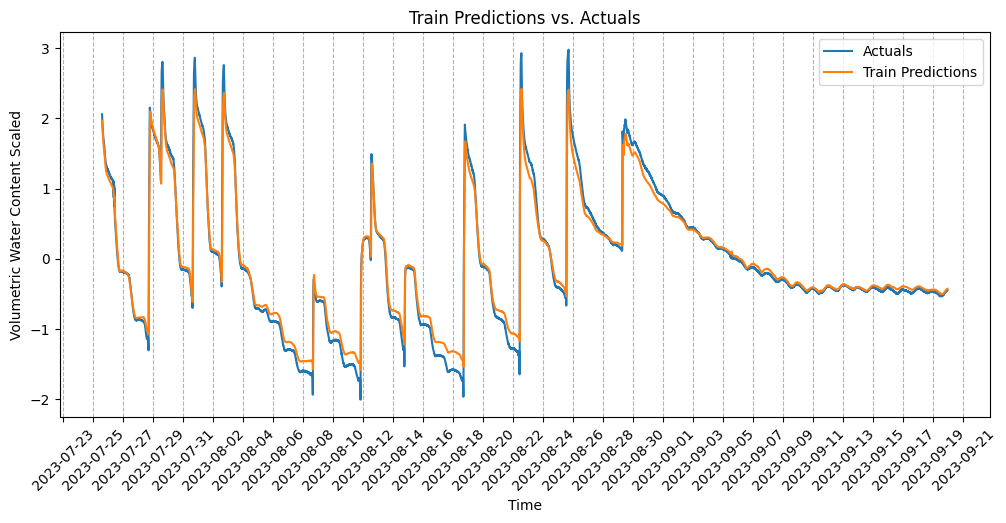

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


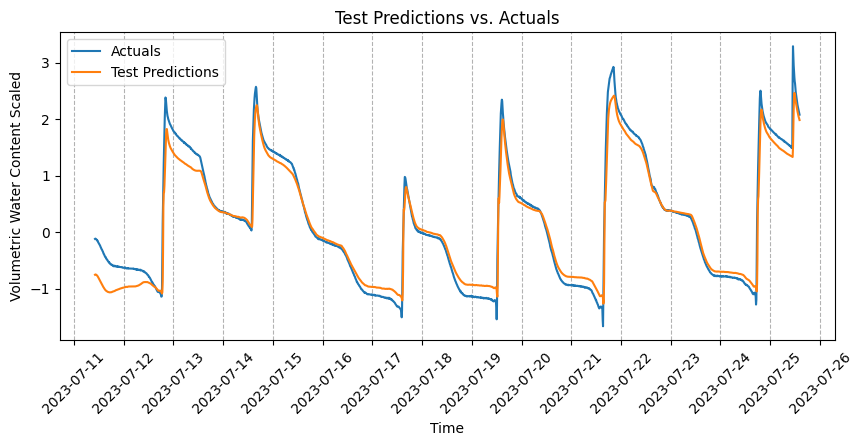

In [44]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


# Create model structure
lstmModel_4 = keras.Sequential(name="lstmModel_4")

lstmModel_4.add(keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2]), name="LSTM_1"))
lstmModel_4.add(keras.layers.Dropout(0.3)) 

lstmModel_4.add(keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001), name="LSTM_2"))
lstmModel_4.add(keras.layers.Dropout(0.3))

lstmModel_4.add(keras.layers.LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001), name="LSTM_3"))
lstmModel_4.add(keras.layers.Dropout(0.3))

lstmModel_4.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.001), name="Dense_1"))
lstmModel_4.add(keras.layers.Dropout(0.2))

lstmModel_4.add(keras.layers.Dense(1, activation='linear', name="Output"))

lstmModel_4.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.001))
lstmModel_4.summary()



# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))


# Callbacks
early_stopping = EarlyStopping(monitor='MAE', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='MAE', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = lstmModel_4.fit(X_train, y_train, epochs=100, shuffle=False, callbacks=[early_stopping, reduce_lr, test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


#TRAIN DATA VISUALIZATION

train_predictions = lstmModel_4.predict(X_train).flatten()
y_train = y_train.flatten()


# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5]

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})


# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = lstmModel_4.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()



<h1> Building GRU Models <h1>

## gruModel_1

Model: "gruModel_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_1 (GRU)                          │ (None, 50)                  │           9,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,501 (37.11 KB)

 Trainable params: 9,501 (37.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.7914 - loss: 1.1827 - smape: 116.8273
Epoch 1 - Test Loss: 0.6572, Test MAE: 0.5316, Test SMAPE: 84.4904
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - MAE: 0.7896 - loss: 1.1787 - smape: 116.6894 - learning_rate: 5.0000e-04
Epoch 2/50
241/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.3019 - loss: 0.1818 - smape: 56.9501
Epoch 2 - Test Loss: 0.4484, Test MAE: 0.4291, Test SMAPE: 69.7668
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - MAE: 0.3000 - loss: 0.1802 - smape: 57.0767 - learning_rate: 5.0000e-04
Epoch 3/50
239/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.2201 - loss: 0.1063 - smape: 48.7731
Epoch 3 - Test Loss: 0.3107, Test MAE: 0.3068, Test SMAPE: 55.9720
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - MAE: 0.2193 - loss: 0.1058 - smape: 48.9186 - learning_rate: 5.0000e-04
Epoch 4/50
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - MAE: 0.1960 - loss: 0.0879 - smape: 43.7553
Epoch 4 - Test Loss: 0.2650, Test MAE: 0.2584, Test SMAPE: 5

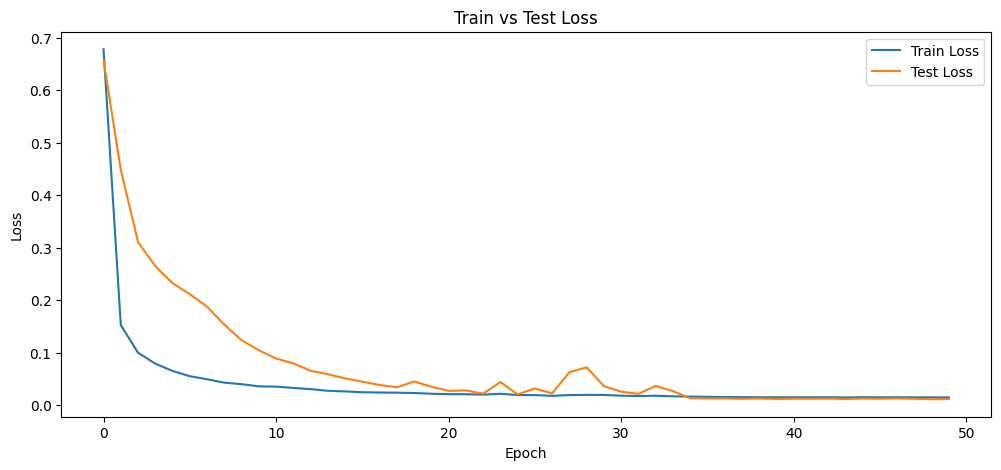

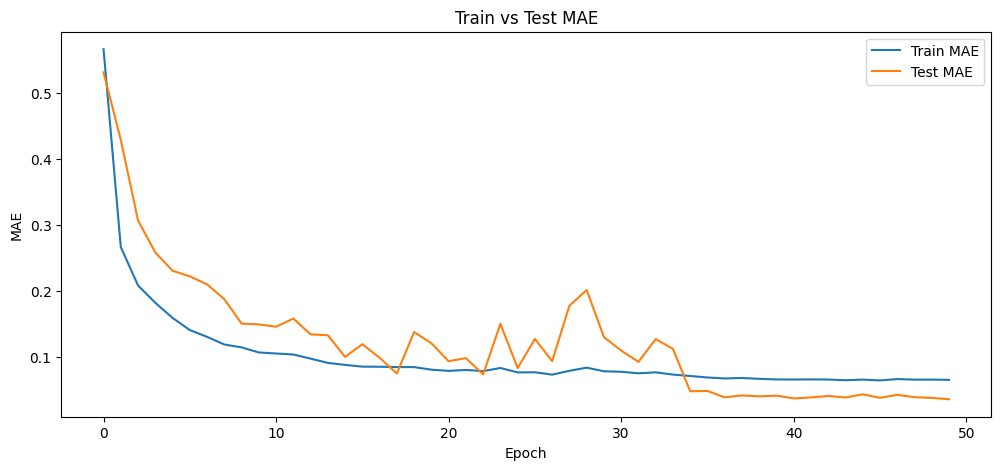

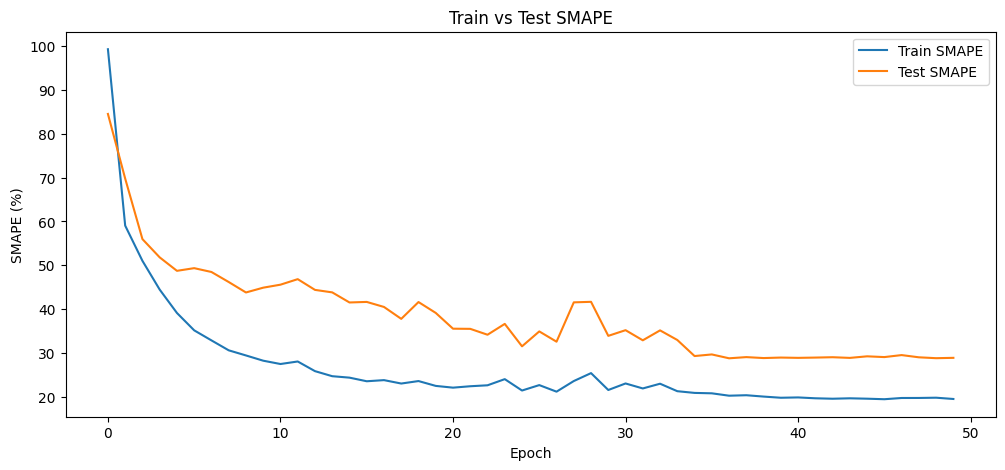

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
8117 8117 8117


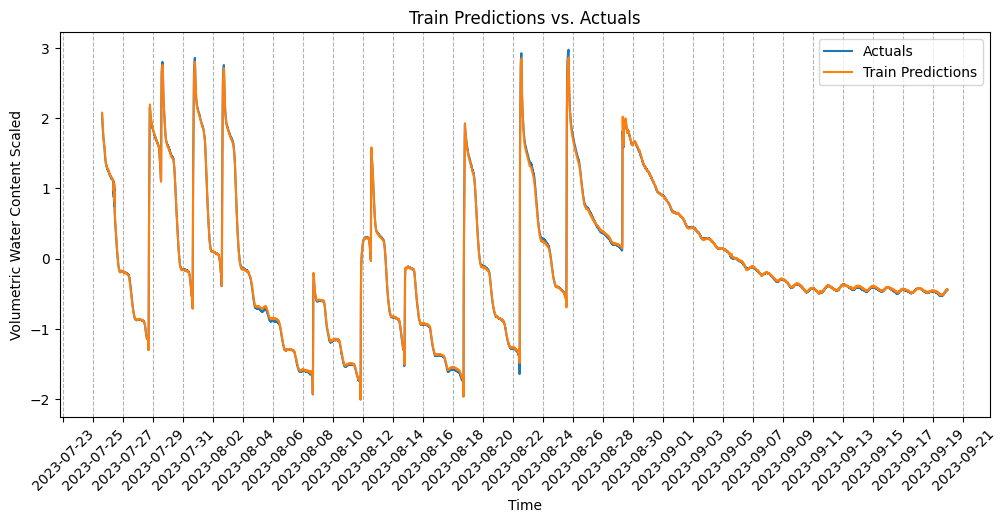

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


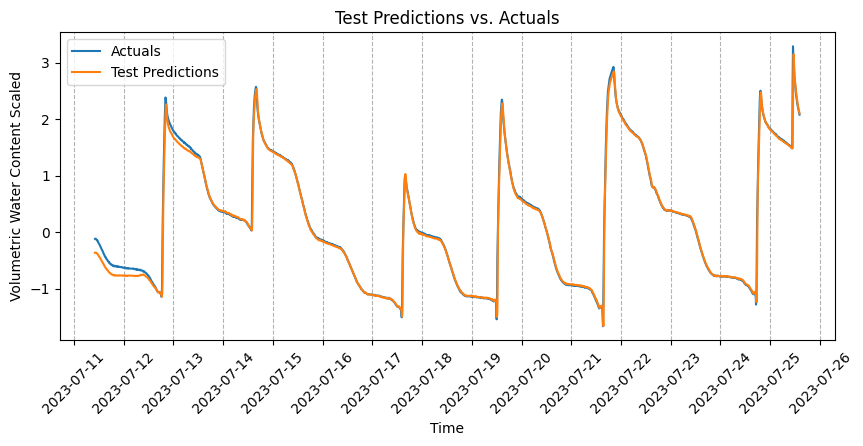

In [70]:
##### import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import matplotlib.dates as mdates
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


# Create model structure
gruModel_1 = keras.Sequential(name="gruModel_1")
gruModel_1.add(keras.layers.GRU(100,return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]),kernel_regularizer=l2(0.001), name="GRU_1")) 
gruModel_1.add(keras.layers.Dropout(0.3))  # Dropout layer to prevent overfitting
gruModel_1.add(keras.layers.Dense(1, activation='linear',kernel_regularizer=l2(0.001), name="Dense_1"))  # Output layer
gruModel_1.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.0005))
gruModel_1.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# Earlu Stopping Callback
reduce_lr = ReduceLROnPlateau(monitor='MAE', factor=0.2, patience=7, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='MAE', patience=15, restore_best_weights=True, verbose=1)

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = gruModel_1.fit(X_train, y_train, epochs=50, shuffle=False, callbacks=[early_stopping, reduce_lr, test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



#TRAIN DATA VISUALIZATION

train_predictions = gruModel_1.predict(X_train).flatten()
y_train = y_train.flatten()


# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5]
print(len(timestamp_training), len(train_predictions), len(y_train))

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})


# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = gruModel_1.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()




## gruModel_2

Model: "gruModel_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ GRU_1 (GRU)                          │ (None, 5, 100)              │          33,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_2 (GRU)                          │ (None, 5, 50)               │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_3 (GRU)                          │ (None, 25)                  │           5,775 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,501 (244.14 KB)

 Trainable params: 62,501 (244.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
251/254 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MAE: 0.4837 - loss: 0.6047 - smape: 83.9440
Epoch 1 - Test Loss: 0.3806, Test MAE: 0.3373, Test SMAPE: 66.6849
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - MAE: 0.4808 - loss: 0.6006 - smape: 83.5652 - learning_rate: 5.0000e-04
Epoch 2/50
249/254 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - MAE: 0.2082 - loss: 0.1944 - smape: 41.3735
Epoch 2 - Test Loss: 0.2345, Test MAE: 0.2270, Test SMAPE: 53.2295
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - MAE: 0.2074 - loss: 0.1938 - smape: 41.2989 - learning_rate: 5.0000e-04
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MAE: 0.1912 - loss: 0.1574 - smape: 37.9658
Epoch 3 - Test Loss: 0.2014, Test MAE: 0.1955, Test SMAPE: 46.3269
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - MAE: 0.1911 - loss: 0.1573 - smape: 37.9575 - learning_rate: 5.0000e-04
Epoch 4/50
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MAE: 0.1847 - loss: 0.1421 - smape: 36.6998
Epoch 4 - Test Loss: 0.1880, Test MAE: 0.2064, Test SM

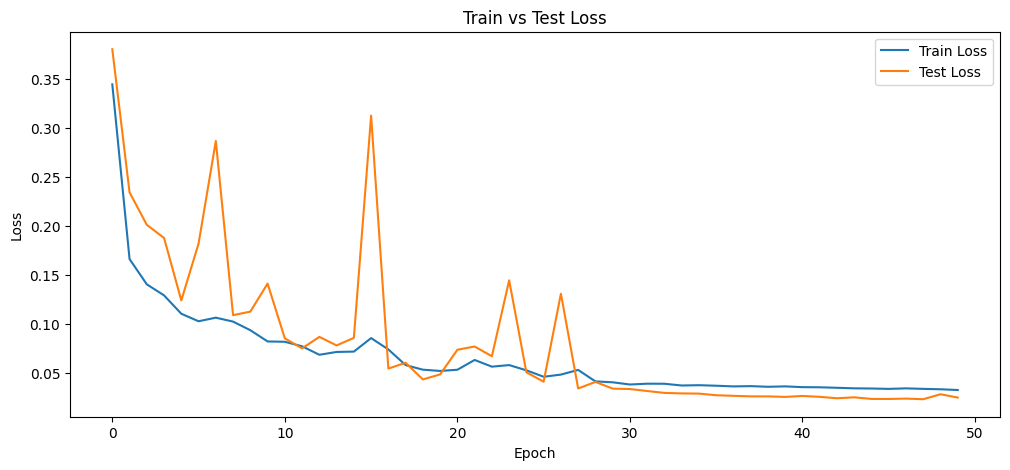

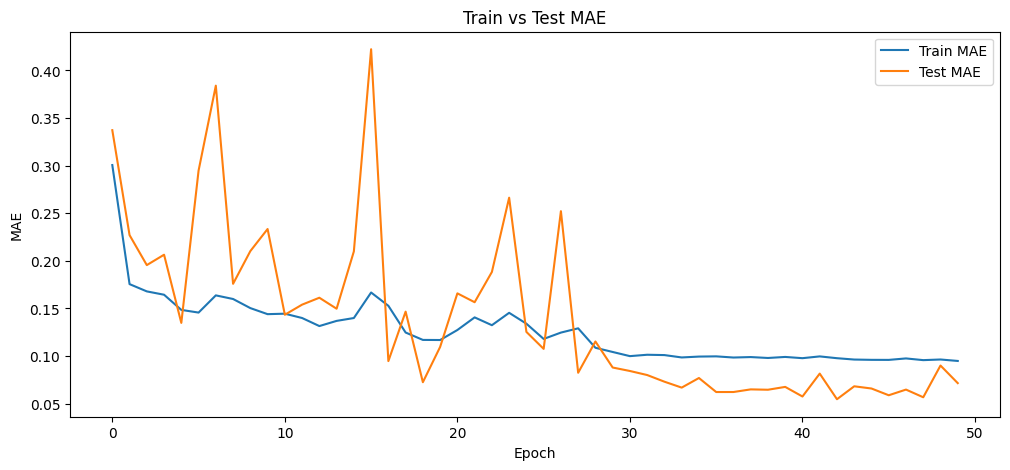

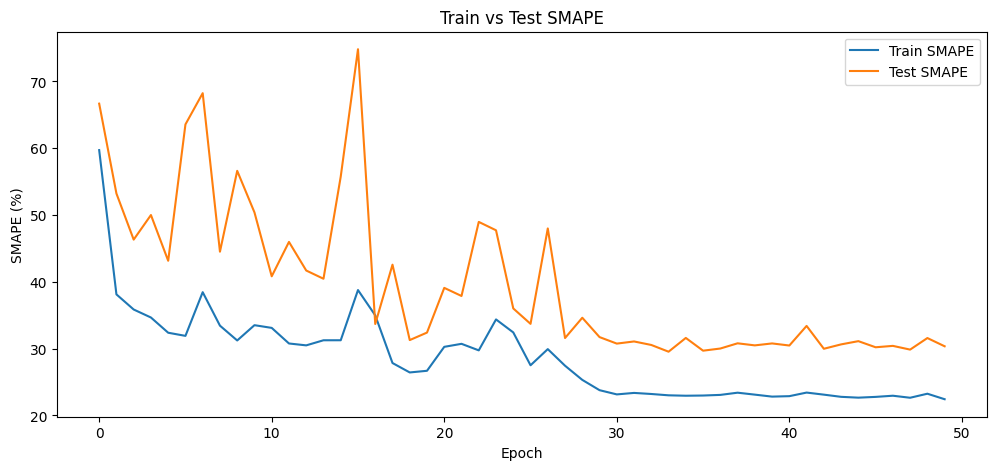

254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


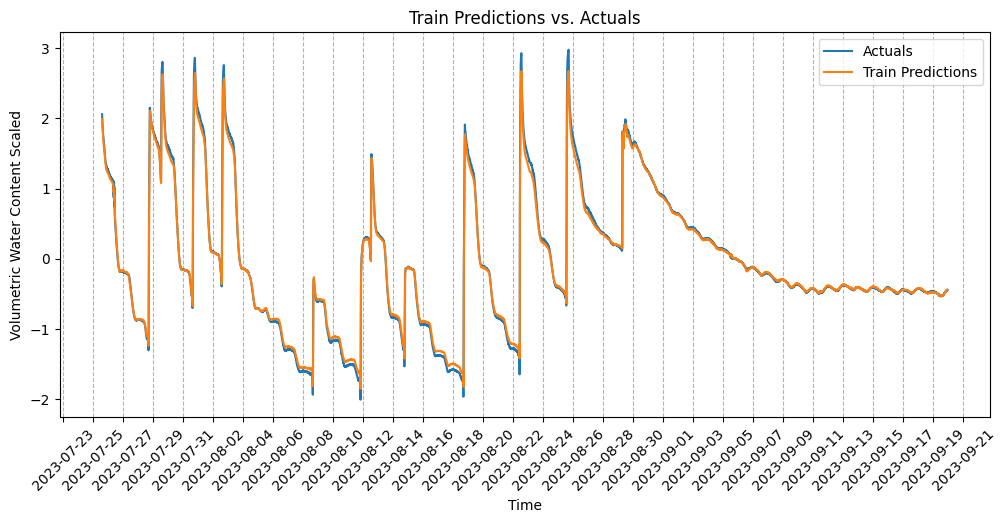

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


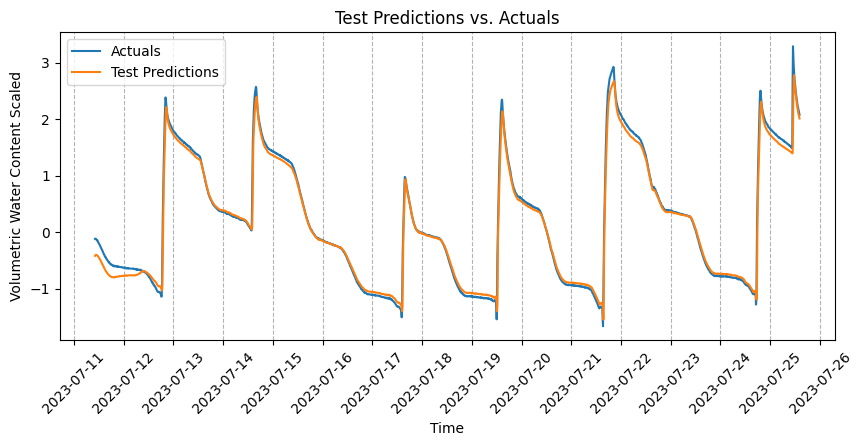

In [75]:
##### import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import matplotlib.dates as mdates
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


# SMAPE function
def smape(y_true, y_pred):
    epsilon = keras.backend.epsilon()
    numerator = abs(y_pred - y_true)
    denominator = (abs(y_true) + abs(y_pred)) / 2.0
    return tf.reduce_mean(numerator / (denominator + epsilon)) * 100

# Callback to calculate test metrics at the end of each epoch
class TestMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_mae = []
        self.test_smape = []

    def on_epoch_end(self, epoch, logs=None):
        X_test, y_test = self.test_data
        loss, mae, smape_value = self.model.evaluate(X_test, y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_mae.append(mae)
        self.test_smape.append(smape_value)
        print(f"\nEpoch {epoch+1} - Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, Test SMAPE: {smape_value:.4f}")


# Create model structure
gruModel_2 = keras.Sequential(name="gruModel_2")
gruModel_2.add(keras.layers.GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001), name="GRU_1"))
gruModel_2.add(keras.layers.Dropout(0.3))  # Dropout layer


gruModel_2.add(keras.layers.GRU(50, return_sequences=True, kernel_regularizer=l2(0.001), name="GRU_2"))
gruModel_2.add(keras.layers.Dropout(0.3))  # Dropout layer

# Terzo strato GRU
gruModel_2.add(keras.layers.GRU(25, kernel_regularizer=l2(0.001), name="GRU_3"))
gruModel_2.add(keras.layers.Dropout(0.3))  # Dropout layer

gruModel_2.add(keras.layers.Dense(1, activation='linear',kernel_regularizer=l2(0.001), name="Dense_1"))  # Output layer
gruModel_2.compile(loss='MeanSquaredError', metrics=['MAE', smape], optimizer=Adam(learning_rate=0.0005))
gruModel_2.summary()

# Instantiate the callback
test_metrics_callback = TestMetricsCallback(test_data=(X_test, y_test))

# Earlu Stopping Callback
reduce_lr = ReduceLROnPlateau(monitor='MAE', factor=0.2, patience=7, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='MAE', patience=15, restore_best_weights=True, verbose=1)

# Convert data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Train model without validation_split
history = gruModel_2.fit(X_train, y_train, epochs=50, shuffle=False, callbacks=[early_stopping, reduce_lr, test_metrics_callback])

# Plot Train vs Test Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(test_metrics_callback.test_loss, label='Test Loss')
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test MAE
plt.figure(figsize=(12, 5))
plt.plot(history.history['MAE'], label='Train MAE')
plt.plot(test_metrics_callback.test_mae, label='Test MAE')
plt.title('Train vs Test MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot Train vs Test SMAPE
plt.figure(figsize=(12, 5))
plt.plot(history.history['smape'], label='Train SMAPE')
plt.plot(test_metrics_callback.test_smape, label='Test SMAPE')
plt.title('Train vs Test SMAPE')
plt.ylabel('SMAPE (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



#TRAIN DATA VISUALIZATION

train_predictions = gruModel_2.predict(X_train).flatten()
y_train = y_train.flatten()


# Ensure df_copy contains the 'timestamp' column
timestamp_training = df_copy['timestamp'].iloc[int(SPLIT * len(X_temp)):]
timestamp_training = timestamp_training[:-5]

train_results = pd.DataFrame(data={'timestamp':timestamp_training, 'Train Predictions':train_predictions, 'Actuals':y_train})


# Plot the test results
plt.figure(figsize=(12, 5))
plt.plot(train_results['timestamp'], train_results['Actuals'], label='Actuals')
plt.plot(train_results['timestamp'], train_results['Train Predictions'], label='Train Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval= 2))  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.title('Train Predictions vs. Actuals')
plt.legend(['Actuals', 'Train Predictions'])
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()


# TEST DATA VISUALIZATION

# Evaluate the model on the test set
test_predicions = gruModel_2.predict(X_test).flatten()
y_test = y_test.flatten()

timestamp_testing = df_copy['timestamp'].iloc[:int(SPLIT * len(X_temp))].reset_index(drop=True)

test_results = pd.DataFrame(data={'timestamp':timestamp_testing, 'Test Predictions':test_predicions, 'Actuals':y_test})

# Plot the test results
plt.figure(figsize=(10, 4))
plt.plot(test_results['timestamp'], test_results['Actuals'], label='Actuals')
plt.plot(test_results['timestamp'], test_results['Test Predictions'], label='Test Predictions')

# Format x-axis to show only dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjusts to show ticks daily

ax = plt.gca()  
ax.xaxis.grid(which="major", color="black", linestyle="--", alpha=0.3)  # Set x-axis grid

plt.xlabel('Time')
plt.ylabel('Volumetric Water Content Scaled')
plt.legend(['Actuals', 'Test Predictions'])
plt.title('Test Predictions vs. Actuals')
plt.xticks(rotation=45)  # Rotate the x-axis labels if they overlap
plt.show()




## Script used to quantize models

Sostiture tutte le occorrenze del nome del modello con quello che si intende quantizzare

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error


# Assicurati che gruModel_2 sia il tuo modello addestrato
model = gruModel_2
model.save('gruModel_2.h5')

# Crea un nuovo modello con input shape specificato
input_shape = (X_train.shape[1], X_train.shape[2])
new_input = tf.keras.Input(shape=input_shape, batch_size=1, dtype=tf.float32)
outputs = model(new_input)
new_model = tf.keras.Model(inputs=new_input, outputs=outputs)
print("Dimensione di X_train:", X_train.shape)  # Es. (1000, timesteps, features)
print("Dimensione di X_test:", X_test.shape)
# Funzione per generare un dataset rappresentativo
def representative_dataset():
    for i in range(1000):  # Usa un sottoinsieme dei tuoi dati
        yield [X_train[i:i+1].astype(np.float32)]

# Configura il convertitore TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)

# Abilita la conversione di operazioni TensorFlow
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Disabilita la lowering delle operazioni TensorList
converter._experimental_lower_tensor_list_ops = False

# Abilita le variabili di risorsa
converter.experimental_enable_resource_variables = True

# Abilita la quantizzazione post-training
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# Imposta la policy di inferenza
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Converti il modello
try:
    tflite_model = converter.convert()
    print("Conversione completata con successo!")
except Exception as e:
    print(f"Errore durante la conversione: {str(e)}")
    print("Tentativo di conversione senza quantizzazione...")
    
    # Se la quantizzazione fallisce, prova senza
    converter.optimizations = []
    converter.representative_dataset = None
    tflite_model = converter.convert()
    print("Conversione completata senza quantizzazione.")

# Salva il modello TFLite
with open('gruModel_2_converted.tflite', 'wb') as f:
    f.write(tflite_model)

print("Modello TFLite salvato con successo.")

# Funzione per eseguire inferenza con il modello TFLite
def run_tflite_model(tflite_file, x_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_file)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    predictions = []
    for i in range(len(x_test)):
        input_data = x_test[i:i+1].astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
    
    return np.array(predictions).flatten()

# Valuta il modello originale
original_predictions = model.predict(X_test).flatten()
original_mse = mean_squared_error(y_test, original_predictions)
original_rmse = np.sqrt(original_mse)

# Valuta il modello TFLite
tflite_predictions = run_tflite_model('gruModel_2_converted.tflite', X_test)
tflite_mse = mean_squared_error(y_test, tflite_predictions)
tflite_rmse = np.sqrt(tflite_mse)

print("\nConfronto delle prestazioni:")
print(f"Modello originale - MSE: {original_mse:.4f}, RMSE: {original_rmse:.4f}")
print(f"Modello TFLite - MSE: {tflite_mse:.4f}, RMSE: {tflite_rmse:.4f}")

# Confronto delle dimensioni dei modelli
import os

original_size = os.path.getsize('gruModel_2.h5')
tflite_size = os.path.getsize('gruModel_2_converted.tflite')

print("\nDimensioni dei modelli:")
print(f"Originale: {original_size / 1024:.2f} KB")
print(f"TFLite: {tflite_size / 1024:.2f} KB")

# Calcola la riduzione percentuale delle dimensioni
tflite_reduction = (1 - tflite_size / original_size) * 100

print(f"\nRiduzione dimensioni TFLite: {tflite_reduction:.2f}%")